# Minimum Snap Trajectory
## Model
* control input $\mathbf u = [u_1, u_2, u_3, u_4]^T$
	* $u_1$ net body force
	* $u_2, u_3, u_4$ body moments according to rotor speeds
* state $\mathbf x = [x, y, z, \phi, \theta, \psi, \dot{x}, \dot{y}, \dot{z}, p, q, r]^T$

## Differential Flatness
* flat outputs $\sigma = [x, y, z , \psi]^T$
	* coordinates of COM $\mathbf r = [x, y, z]^T$
	* yaw angle $\psi$


## Trajectory Optimization
Quadratic Program (QP):
$$
\min\int_{t_o}^{t_m}
\mu_r \left|\left|\frac{d^{k_r}\mathbf{r}_{\text{T}}}{dt^{k_r}}\right|\right| +
\mu_\psi \left|\left|\frac{d^{k_\psi}\psi_{\text{T}}}{dt^{k_\psi}}\right|\right|
dt
$$
s.t.
$$
\begin{aligned}
\sigma_T(t_i)&=\sigma_i ,&\qquad j = 0, \dots, m \\
\left.\frac{d^Px_T}{dt^P}\right|_{t=t_j} &= 0 \text{ or free,} &\qquad  j = 0, \dots, m; p=1, \dots, k_r \\
\left.\frac{d^Py_T}{dt^P}\right|_{t=t_j} &= 0 \text{ or free,} &\qquad  j = 0, \dots, m; p=1, \dots, k_r \\
\left.\frac{d^Pz_T}{dt^P}\right|_{t=t_j} &= 0 \text{ or free,} &\qquad  j = 0, \dots, m; p=1, \dots, k_r \\
\left.\frac{d^P\psi_T}{dt^P}\right|_{t=t_j} &= 0 \text{ or free,} &\qquad  j = 0, \dots, m; p=1, \dots, k_\psi
\end{aligned}
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re, math

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

from IPython.display import HTML, display

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import cm
from numpy import linspace
from matplotlib.colors import LogNorm
from decimal import *

def deg2rad(deg):
    return deg / 180. * np.pi

keyframes = [
    [0, 0, deg2rad(0)],
    [2, 0, deg2rad(90)],
    [2, 6, deg2rad(180)],
    [0, 6, deg2rad(0)]
]
times = [0, 0.3, 0.7, 1.0]

## Nondimensionalization
Quantities $x_t, y_T, z_T, \psi_T$ are decoupled in cost function and constraints of the QP.
Hence, they can be separated into 4 optimization problems. Considering a general form for a nondimensional variable $\tilde{w}(\tau)$ where $\tau$ represents nondimensionalized time:
$$
\begin{aligned}
\min &\int_0^1 \frac{d^k\tilde{w}(\tau)^2}{d\tau^k}d\tau&\\
\text{s.t.} &\qquad \tilde{w}(\tau_i) = \tilde{w}_i, &\qquad i=0,\dots,m\\
&\qquad \left.\frac{d^P\tilde{w}(\tau)}{d\tilde{w}^P}\right|_{\tau=\tau_j}=0\text{ or free}, &\qquad t_j=0,\dots,1; p=1,\dots,k
\end{aligned}
$$

In [3]:
k = 3 # dimensions
d = 5 # polynomial degree

C = [
    [0, 0, 1],
    [1, 0, 0]
]

times = np.linspace(0, 1, 100)

def polynomial(times, constraints, continuity=2, degree=4):
    pass

### Evaluation for a single, piecewise polynomial

In [4]:
x_s = [0, 0]
x_f = [3, 6]
degree = 2
dimensions = 2
times = np.linspace(0, 1, 100)

C = x_s + x_f
np.linalg.pinv

def time_matrix(t, rows, cols):    
    return np.poly1d([t] * cols)

The $(d+1)\times (c+1)$ time matrix is computed for a specific time $t$ and stores in each column the monomials of the $c_i$-th derivative ($c_i\in[0,c]$) of a $d$ degree polynomial which are evaluated at time $t$.

For example, for degree $d=5$ and continuity $c=3$, we get the following time matrix at time $t=2$:
$$
\begin{pmatrix}
t^5 & 5t^4 & 20t^3 & 60t^2 \\
t^4 & 4t^3 & 12t^2 & 24t   \\
t^3 & 3t^2 & 6t    & 6     \\
t^2 & 2t   & 2     & 0     \\
t^1 & 1    & 0     & 0     \\
t^0 & 0    & 0     & 0 
\end{pmatrix}
=\begin{pmatrix}
32 & 80 & 160 & 240 \\
16 & 32 & 48  & 48  \\
8  & 12 & 12  & 6     \\
4  & 4  & 2   & 0     \\
2  & 1  & 0   & 0     \\
1  & 0  & 0   & 0 
\end{pmatrix}
$$

In [192]:
def time_matrix(time, degree, continuity):
    time_matrix = np.zeros((degree+1, continuity+1))

    poly = np.poly1d([1] * (degree+1))
    for derivation in range(continuity+1):
        time_matrix[:int(len(poly)+1), derivation] = [c*time**d for c, d in zip(poly, range(len(poly),-1,-1))]
        # print "p%s(%i) = %s\n%s" % ("'" * derivation, t, str([c*t**d for c, d in zip(poly, range(len(poly),-1,-1))] + [0]*(continuity-len(poly)-1)), poly)
        poly = np.polyder(poly)

    return time_matrix

Given start and end constraints $\mathbf x_s, \mathbf x_f$, the following method computes the space of polynomials that satisfy these constraints.

Continuity is the number of derivatives that shall be computed per polynomial (one polynomial for each time step).

In [149]:
import scipy
import numpy as np
from scipy import linalg, matrix
# computes the null space of a matrix A
def null_space(A, eps=1e-12):
    u, s, vh = scipy.linalg.svd(A)
    padding = max(0,np.shape(A)[1]-np.shape(s)[0])
    null_mask = np.concatenate(((s <= eps), np.ones((padding,),dtype=bool)),axis=0)
    null_space = scipy.compress(null_mask, vh, axis=0)
    return scipy.transpose(null_space)

In [445]:
def piecewise_min_snap(x_s, x_f, times, degree=4):
    dimensions = x_s.shape[0]
    cperdim = x_s.shape[1]
    continuity = cperdim # or number of columns in a constraint
    
    dd = degree + 1
    cc = continuity + 1

    n_columns = (len(times)-2) * cc + cperdim + cperdim
    n_rows = (len(times)-1) * dd

    print "Columns:", n_columns
    print "Rows:", n_rows
    print "Dimensions:", dimensions
    # knot_intervals = np.diff(times)
    # time_scale = 1 / np.max(knot_intervals)
    # times *= time_scale

    constraints = np.zeros((dimensions, n_columns))
    constraints[:, :cperdim] = x_s
    constraints[:, -cperdim:] = x_f
    print "Constraints:", constraints.shape
    # print constraints

    zero_time_matrix = -time_matrix(0, degree, continuity)
    # print "Zero Time Matrix:\n", zero_time_matrix

    polynomials = np.zeros((n_rows, n_columns))
    print "Polynomials:", polynomials.shape
    polynomials[:dd, :cperdim] = time_matrix(times[0], degree, cperdim-1)
    for i in range(2, len(times)):
        col = (i-2) * cc + cperdim
        row = (i-2) * dd
        polynomials[row:row+dd, col:col+cc] = \
            time_matrix(times[i]-times[i-1], degree, continuity)
        polynomials[row+dd:row+2*dd, col:col+cc] = zero_time_matrix

    polynomials[-dd:, -cperdim:] = \
        time_matrix(times[-1]-times[-2], degree, cperdim-1)

    # print (polynomials[:13, :13])
    # print (polynomials[-13:, -13:])
    solution = (constraints.dot(np.linalg.pinv(polynomials)))
    free = null_space(polynomials.T)
    print "Solution:", solution.shape
    print "Null space:", free.shape

    return solution, free

x_s = np.array([[2, 0, 0], [9, 0, 0]])
x_f = np.array([[5, 0, 0], [2, 0, 0]])
degree = 4
times = np.linspace(0, 1, 6)
solution, free = piecewise_min_snap(x_s, x_f, times, degree)

Columns: 22
Rows: 25
Dimensions: 2
Constraints: (2, 22)
Polynomials: (25, 22)
Solution: (2, 25)
Null space: (25, 3)


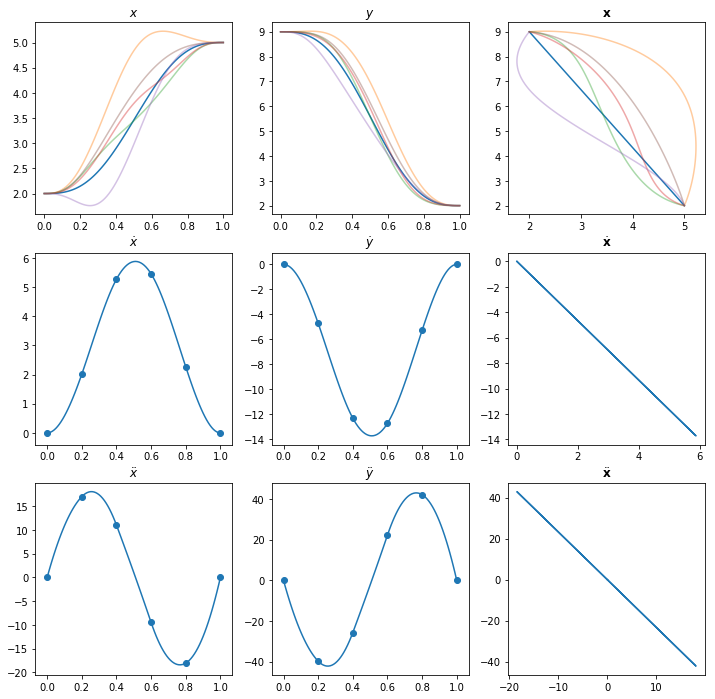

In [366]:
def plot_solution(ax, sol, intermediary=20, alpha=1):
    curve = []
    ts = []
    for i, (t1, t2) in enumerate(zip(times, times[1:])):
        poly = np.poly1d((sol[i, :]))
        if i == 0:
            curve.append(np.polyval(poly, 0))
            ts.append(0)
        step = (t2-t1) / intermediary
        for j in range(1, intermediary+1):
            curve.append(np.polyval(poly, j*step))
            ts.append(t1 + j*step)
    ax.plot(ts, curve, alpha=alpha)
    return curve

def plot_derivation(ax, sol, der=1, intermediary=20, alpha=1):
    curve = []
    ts = []
    dots = []
    for i, (t1, t2) in enumerate(zip(times, times[1:])):
        poly = np.poly1d((sol[i, :]))
        poly = np.polyder(poly, m=der)
        if i == 0:
            curve.append(np.polyval(poly, 0))
            ts.append(0)
        step = (t2-t1) / intermediary
        dots.append(np.polyval(poly, 0))
        for j in range(1, intermediary+1):
            curve.append(np.polyval(poly, j*step))
            ts.append(t1 + j*step)
        if i == len(times)-2:
            dots.append(np.polyval(poly, t2-t1))
    ax.plot(ts, curve, alpha=alpha)
    ax.scatter(times, dots)
    return curve

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 12))
ax1.set_title("$x$")
ax2.set_title("$y$")
ax3.set_title("$\\bf x$")
xs = plot_solution(ax1, solution[0,:].reshape((-1, dd)))
ys = plot_solution(ax2, solution[1,:].reshape((-1, dd)))
ax3.plot(xs, ys)
for k in range(5):
    r = 500 * (np.random.rand(free.shape[1], 1) - 0.5)
    sol = solution + free.dot(r).T
#     sol = sol.reshape((-1, dd))
    xs = plot_solution(ax1, sol[0,:].reshape((-1, dd)), alpha=0.4)
    ys = plot_solution(ax2, sol[1,:].reshape((-1, dd)), alpha=0.4)
    ax3.plot(xs, ys, alpha=0.4)
    
ax4.set_title("$\\dot{x}$")
ax5.set_title("$\\dot{y}$")
ax6.set_title("$\\dot{\\bf x}$")
xs = plot_derivation(ax4, solution[0,:].reshape((-1, dd)))
ys = plot_derivation(ax5, solution[1,:].reshape((-1, dd)))
ax6.plot(xs, ys)
ax7.set_title("$\\ddot{x}$")
ax8.set_title("$\\ddot{y}$")
ax9.set_title("$\\ddot{\\bf x}$")
xs = plot_derivation(ax7, solution[0,:].reshape((-1, dd)), der=2)
ys = plot_derivation(ax8, solution[1,:].reshape((-1, dd)), der=2)
ax9.plot(xs, ys)

Columns: 22
Rows: 25
Dimensions: 2
Constraints: (2, 22)
Polynomials: (25, 22)
Solution: (2, 25)
Null space: (25, 3)
UCB: -0.081686744968
-0.000737293948966
-0.0699829798224
-0.442756839269
-0.190007914278
-0.253962227709
-0.00994219662561
-0.488752832378
-0.0143148220619
-0.0530234698595
-0.442756839269
-0.081686744968
-0.502924732839
-0.0766369891164
-0.00384882390699
-0.555201129666
Optimization terminated successfully.
         Current function value: 0.000513
         Iterations: 20
         Function evaluations: 96
  status: 0
    nfev: 96
 success: True
     fun: 0.00051307100691631337
       x: array([-11.66750469, -36.72243603,  31.23722262])
 message: 'Optimization terminated successfully.'
     nit: 20


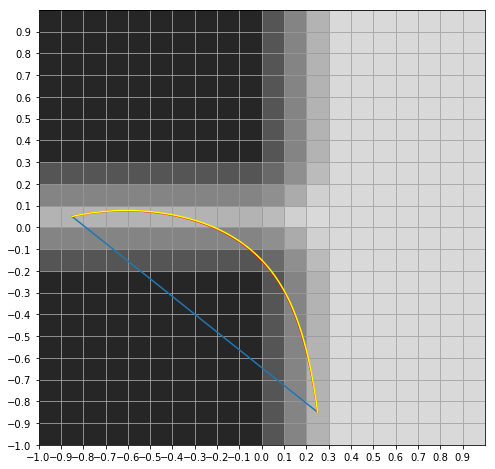

In [508]:
# generate 2d toy map
voxel_size = 0.1
xmin, xmax = -1, 1
ymin, ymax = -1, 1

obstacle1 = [
    (-1, -1),  # left bottom
    (-.1, -.3) # right top
]

obstacle2 = [
    (-1, .3), # left bottom
    (-.1, 1)  # right top
]

smoothness = 1.9 * voxel_size
certainty = 0.7
prior = 0.5

def generate_voxel_patch(x, y, mean=None, color=None):
    return patches.Rectangle(
        xy=(x, y),
        width=voxel_size,
        height=voxel_size,
        color="black" if color is None else color,
        alpha=1 if mean is None else mean)

def bernoulli_std(p):
    return np.sqrt(p * (1-p))

def distance_point_rect(p, rect_center, rect_dim):
    dx = max(abs(p[0] - rect_center[0]) - rect_dim[0] / 2, 0)
    dy = max(abs(p[1] - rect_center[1]) - rect_dim[1] / 2, 0)
    return np.sqrt(dx ** 2 + dy ** 2)

def estimate_map(x, y):
    if ((obstacle1[0][0] <= x <= obstacle1[1][0]) and (obstacle1[0][1] <= y <= obstacle1[1][1])) or \
        ((obstacle2[0][0] <= x <= obstacle2[1][0]) and (obstacle2[0][1] <= y <= obstacle2[1][1])):
            # obstacle
            mean = prior + certainty * (1 - prior)
#             print mean
            return mean, bernoulli_std(mean)
    else:
        obstacle1_center = np.mean([obstacle1[0], obstacle1[1]], axis=0)
        obstacle1_dim = np.abs(np.array(obstacle1[1]) - np.array(obstacle1[0]))
#         print obstacle1_center
#         print obstacle1_dim
        dist1 = distance_point_rect((x, y), obstacle1_center, obstacle1_dim)
        obstacle2_center = np.mean([obstacle2[0], obstacle2[1]], axis=0)
        obstacle2_dim = np.abs(np.array(obstacle2[1]) - np.array(obstacle2[0]))
        dist2 = distance_point_rect((x, y), obstacle2_center, obstacle2_dim)
#         print dist1 + dist2
        n = prior
        m = -n / smoothness
        truth = max(m * (min(dist1, dist2) - smoothness) + n, 0)
#         print dist1 + dist2, truth
        mean = (truth - prior) * certainty + prior
#         print mean
        return mean, bernoulli_std(mean)

xdim = int((xmax-xmin) / voxel_size + 1)
ydim = int((ymax-ymin) / voxel_size + 1)
world = [[() for i in range(xdim)] for j in range(ydim)]
for i in range(xdim):
    x = xmin + i * voxel_size
    for j in range(ydim):
        y = ymin + j * voxel_size
        world[i][j] = estimate_map(x, y)


fig, ((ax)) = plt.subplots(1, 1, figsize=(8, 8))
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xticks(np.arange(xmin, xmax, voxel_size))
ax.set_yticks(np.arange(ymin, ymax, voxel_size))
ax.grid()

for i in range(xdim):
    x = xmin + i * voxel_size
    for j in range(ydim):
        y = ymin + j * voxel_size
        ax.add_patch(generate_voxel_patch(x, y, world[i][j][0]))

x_s = np.array([[ 0.25, 0, 0], [-0.85, 0, 0]])
x_f = np.array([[-0.85, 0, 0], [ 0.05, 0, 0]])
degree = 4
times = np.linspace(0, 1, 6)
solution, free = piecewise_min_snap(x_s, x_f, times, degree)
xs = plot_solution(ax1, solution[0,:].reshape((-1, dd)))
ys = plot_solution(ax2, solution[1,:].reshape((-1, dd)))
ax.plot(xs, ys)

def evaluate(solution, kappa=1.6):
    xs = plot_solution(ax1, solution[0,:].reshape((-1, dd)))
    ys = plot_solution(ax2, solution[1,:].reshape((-1, dd)))

    # draw occupied voxels
    occupied = set()
    for x, y in zip(xs, ys):
        i = int((x - xmin) / voxel_size)
        j = int((y - ymin) / voxel_size)
        if i < 0 or j < 0 or i >= xdim or j >= ydim:
            return -1000
        occupied.add((i, j))
    
    reach_left, reach_right = Decimal(1), Decimal(1)
    reach = 1.
    for (i, j) in occupied:
#         x = xmin + i * voxel_size
#         y = ymin + j * voxel_size
#         ax.add_patch(generate_voxel_patch(x, y, 0.5, color="orange"))
        
        std, mean = world[i][j]
        var = Decimal(std) ** Decimal(2)
        mean_sq = Decimal(1.-mean) ** Decimal(2)
        reach_left *= var + mean_sq
        reach_right *= mean_sq        
        reach *= 1. - mean
        
    var_reachability = reach_left - reach_right    
    KAPPA = Decimal(kappa)
    ucb = float(Decimal(reach) - var_reachability.sqrt() * KAPPA)
    return ucb
    
print "UCB:", evaluate(solution)

best_ucb = (evaluate(solution), xs, ys, 100 * (np.random.rand(free.shape[1], 1) - 0.5))
for k in range(15):
    r = 100 * (np.random.rand(free.shape[1], 1) - 0.5)
    sol = solution + free.dot(r).T
    xs = plot_solution(ax1, sol[0,:].reshape((-1, dd)), alpha=0.4)
    ys = plot_solution(ax2, sol[1,:].reshape((-1, dd)), alpha=0.4)
    ucb = evaluate(sol)
    print ucb
    if ucb > best_ucb[0]:
        best_ucb = (ucb, xs, ys, r)
#     ax.plot(xs, ys, alpha=0.6)
ax.plot(best_ucb[1], best_ucb[2], color="red")

r = best_ucb[3]
def best_ucb(params):
    sol = solution + free.dot(np.array(params)).T
    xs = plot_solution(ax1, sol[0,:].reshape((-1, dd)), alpha=0.4)
    ys = plot_solution(ax2, sol[1,:].reshape((-1, dd)), alpha=0.4)
    ucb = evaluate(sol)
    return -ucb  # maximize, i.e. minimize negative UCB


from scipy.optimize import minimize

# res = minimize(best_ucb, r, method='Powell', options={'xtol': 1e-15, 'ftol': 1e-15, 'disp': True, 'maxiter': 2000, 'maxfev': 2000})
res = minimize(best_ucb, r, method='Nelder-Mead', options={'xtol': 1e-5, 'disp': True, 'maxiter': 100})
# minimizer_kwargs = {"method": "Powell"}
# res = scipy.optimize.basinhopping(best_ucb, r, minimizer_kwargs=minimizer_kwargs, niter=100)

print res
r = np.array(res.x)
sol = solution + free.dot(r).T
xs = plot_solution(ax1, sol[0,:].reshape((-1, dd)), alpha=0.4)
ys = plot_solution(ax2, sol[1,:].reshape((-1, dd)), alpha=0.4)
ax.plot(xs, ys, color="yellow")